In [1]:
import datetime
from concurrent.futures import ThreadPoolExecutor

import pandas as pd
from tqdm import tqdm

from hackernews_api import get_comments_by_user

In [2]:
adhd_usernames = set(pd.read_csv("./data/adhd_usernames.csv")["by"])
ctrl_usernames = set(pd.read_csv("./data/random_usernames.csv")["by"]).difference(adhd_usernames)
len(adhd_usernames), len(ctrl_usernames)

(1525, 9980)

In [3]:
MAX_COMMENTS = 1000 # The maximum allowed by the HN API.

def get_comments_by_user_threaded(user: str) -> list[tuple[str, str, datetime.datetime]]:
    comments = get_comments_by_user(user, max_comments=MAX_COMMENTS)
    return [(user, *comment_dt) for comment_dt in comments]

def get_comments(usernames: set[str]) -> list[tuple[str, str, datetime.datetime]]:
    data = []
    with ThreadPoolExecutor(max_workers=16) as executor:
        results = list(tqdm(executor.map(get_comments_by_user_threaded, usernames), total=len(usernames)))
    
    for result in results:
        data.extend(result)
    return data

In [6]:
adhd_comments = get_comments(adhd_usernames)

100%|██████████| 1525/1525 [05:59<00:00,  4.25it/s]


In [4]:
ctrl_comments = get_comments(ctrl_usernames)

100%|██████████| 9980/9980 [39:39<00:00,  4.19it/s]  


In [7]:
columns = ["username", "comment", "created_at"]
adhd_df = pd.DataFrame(adhd_comments, columns=columns)
ctrl_df = pd.DataFrame(ctrl_comments, columns=columns)

adhd_df["reported_adhd"] = 1
ctrl_df["reported_adhd"] = 0
columns = columns + ["reported_adhd"]

comments_df = pd.concat((adhd_df, ctrl_df), ignore_index=True).dropna()
comments_df = comments_df[~comments_df["comment"].str.contains("adhd|ADHD|ADD", case=True)]

comments_df.to_csv("./data/comments.csv", columns=columns, index=False)

In [ ]:
# NOTE: Skip to this cell to avoid re-downloading the comments via the API
comments_df = pd.read_csv("./data/comments.csv")
comments_df["created_at"] = pd.to_datetime(comments_df["created_at"])

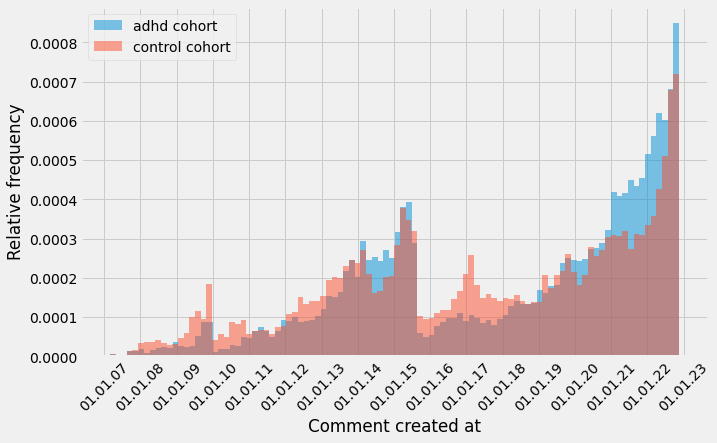

In [ ]:
# Check for differences in the distributions of ADHD and control posting w.r.t time:
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [10, 6]

adhd_comments = comments_df[comments_df["reported_adhd"] == 1]
ctrl_comments = comments_df[comments_df["reported_adhd"] == 0]

fig, ax = plt.subplots(1, 1)
ax.hist(adhd_comments["created_at"], bins=100, alpha=0.5, density=True, label="adhd cohort")
ax.hist(ctrl_comments["created_at"], bins=100, alpha=0.5, density=True, label="control cohort")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
plt.xticks(rotation=45)
plt.xlabel("Comment created at")
plt.ylabel("Relative frequency")
plt.legend(); plt.show()

**Distinct distributions**

Clearly the ADHD and control groups have different posting distributions in the time-dimension. To avoid leaking a signal unrelated to our target variable (reported ADHD), we will restrict to a 5-year posting period: 2018-01-01 to 2023-01-01.

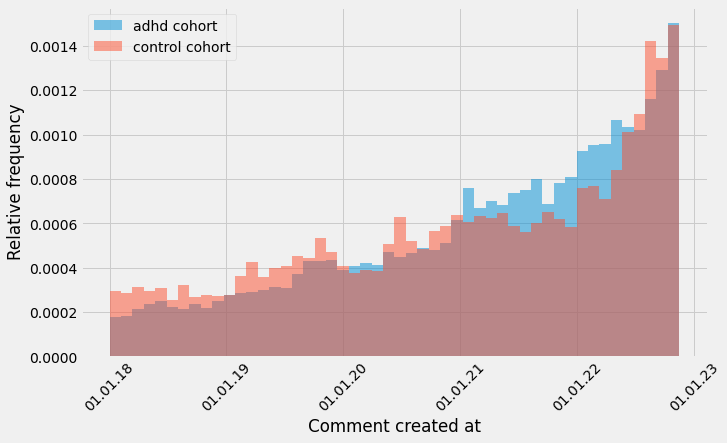

In [ ]:
time_slice_comments_df   = comments_df[
    (comments_df["created_at"] >  datetime.datetime(2018, 1, 1)) &
    (comments_df["created_at"] <= datetime.datetime(2023, 1, 1))
]
time_slice_adhd_comments = time_slice_comments_df[time_slice_comments_df["reported_adhd"] == 1]
time_slice_ctrl_comments = time_slice_comments_df[time_slice_comments_df["reported_adhd"] == 0]

fig, ax = plt.subplots(1,1)
ax.hist(time_slice_adhd_comments["created_at"], bins=50, alpha=0.5, density=True, label="adhd cohort")
ax.hist(time_slice_ctrl_comments["created_at"], bins=50, alpha=0.5, density=True, label="control cohort")

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
plt.xticks(rotation=45)
plt.xlabel("Comment created at")
plt.ylabel("Relative frequency")
plt.legend(); plt.show()

By selecting this date range we've got a more similar distribution of posting between the cohorts.
Because we've made the date range smaller there is less signal to be leaked from differences in posting times,
since the drift in lexical use is relatively smaller.

In [ ]:
groupby_expression = time_slice_comments_df.groupby("username")
aggregated_df      = groupby_expression.aggregate({
                        "comment": lambda x: "\n\n\n".join([str(comment) for comment in x]),
                        "reported_adhd": "any"
                    }).reset_index()

min_words = 250
length_before = len(aggregated_df)
aggregated_df = aggregated_df[aggregated_df["comment"].apply(lambda comment: len(comment.split(" ")) >= min_words)]
print(f"Dropped:   {length_before - len(aggregated_df)} rows with insufficient text.")
print(f"Remaining: {len(aggregated_df)} rows.")

Dropped:   1371 rows with insufficient text.
Remaining: 1262 rows.


In [ ]:
from utils.estimate_age import estimate_author_age
from utils.estimate_gender import estimate_author_is_female

aggregated_df["estimated_age"]      = aggregated_df["comment"].apply(estimate_author_age)
aggregated_df["estimate_is_female"] = aggregated_df["comment"].apply(estimate_author_is_female)

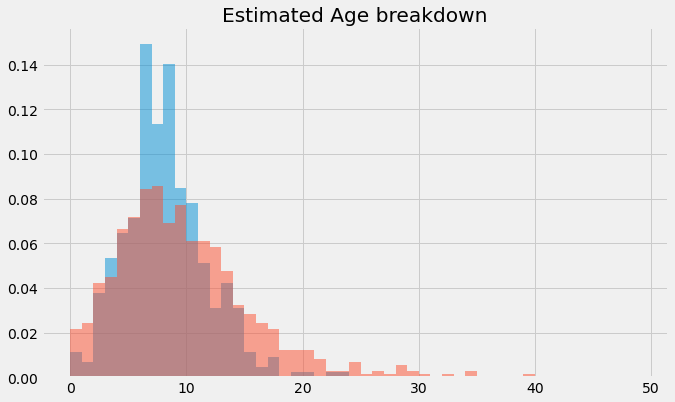

In [ ]:
plt.hist(aggregated_df[aggregated_df["reported_adhd"] == 1]["estimated_age"], bins=range(0, 50, 1), density=True, alpha=0.5, label="ADHD")
plt.hist(aggregated_df[aggregated_df["reported_adhd"] == 0]["estimated_age"], bins=range(0, 50, 1), density=True, alpha=0.5, label="control")
plt.title("Estimated Age breakdown")
plt.legend(); plt.show()

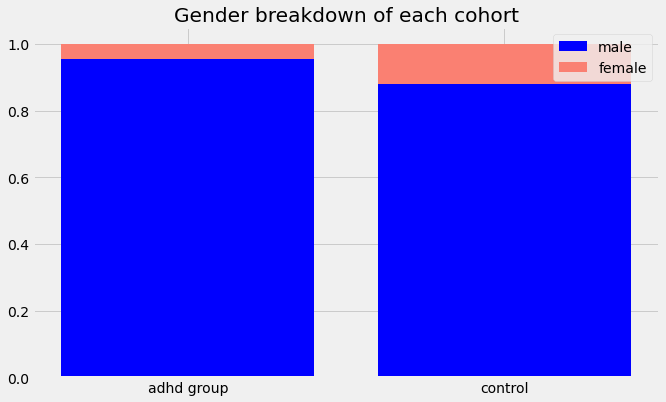

In [ ]:
labels_set = False
def barplot_gender_split(series: pd.Series, group: str):
    is_female: list[bool] = [x >= 0 for x in series]

    global labels_set
    total_people    = len(is_female)
    female_fraction = sum(is_female) / total_people
    male_fraction   = 1 - female_fraction

    # Don't set the labels twice; it clutters things.
    plt.bar(group, male_fraction,   label="male"   if not labels_set else None, color="blue")
    plt.bar(group, female_fraction, label="female" if not labels_set else None, color="salmon", bottom=male_fraction)
    labels_set = True

adhd = aggregated_df.where(aggregated_df["reported_adhd"] == True).dropna()
ctrl = aggregated_df.where(aggregated_df["reported_adhd"] == False).dropna()

barplot_gender_split(adhd["estimate_is_female"], "adhd group")
barplot_gender_split(ctrl["estimate_is_female"], "control")

plt.title("Gender breakdown of each cohort")
plt.legend()
plt.show()
plt.savefig("gender_breakdown.png")

In [ ]:
age_bracket_to_male_female_count: dict[str, tuple[int, int]] = {}

def filter_within_age_bounds(sr: pd.Series, lower_bound: int, upper_bound: int) -> list[bool]:
    """Create a mask selecting for items values in the domain: [lower, upper)"""
    return (sr >= lower_bound) & (sr <= upper_bound)

# Stratify by age
dataframes = []

stepsize = 5 # in years
for lower_bound in range(0, 80, stepsize):
    upper_bound = lower_bound + stepsize

    adhd_age_stratified = adhd[filter_within_age_bounds(adhd["estimated_age"], lower_bound, upper_bound)]
    ctrl_age_stratified = ctrl[filter_within_age_bounds(ctrl["estimated_age"], lower_bound, upper_bound)]

    adhd_women = len(adhd_age_stratified[adhd_age_stratified["estimate_is_female"] >= 0])
    adhd_men   = len(adhd_age_stratified) - adhd_women

    ctrl_age_stratified_females = ctrl_age_stratified[ctrl_age_stratified["estimate_is_female"] >= 0]
    ctrl_age_stratified_males   = ctrl_age_stratified[ctrl_age_stratified["estimate_is_female"] <  0]

    stratified_dfs = [adhd_age_stratified, ctrl_age_stratified_males.sample(adhd_men, random_state=7777)]

    # XXX - Too few women to form a control sample don't use em.
    if adhd_women:
        stratified_dfs.append(ctrl_age_stratified_females.sample(adhd_women, random_state=7777))

    dataframes.extend(stratified_dfs)
    print(f"Men/Women in the age range [{lower_bound:<2}, {upper_bound}): {adhd_men:<3} / {adhd_women:<3}")

stratified_balanced_dataset = pd.concat(dataframes, ignore_index=True)
stratified_balanced_dataset.to_csv("./data/comments_stratified_balanced.csv")

Men/Women in the age range [0 , 10): 320 / 9  
Men/Women in the age range [10, 20): 109 / 8  
Men/Women in the age range [20, 30): 3   / 0  
Men/Women in the age range [30, 40): 0   / 0  
Men/Women in the age range [40, 50): 0   / 0  
Men/Women in the age range [50, 60): 0   / 0  
Men/Women in the age range [60, 70): 0   / 0  
Men/Women in the age range [70, 80): 0   / 0  
